<a href="https://colab.research.google.com/github/Yogesh-8998/Energy-Appliances-Prediction/blob/main/Appliances_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from operator import add
import seaborn as sns
import datetime as dt
 
%matplotlib inline
 
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Almabetter /Machine Learning/Capstone Project /data_application_energy.csv")

In [ ]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [ ]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
df.isnull

<bound method DataFrame.isnull of                       date  Appliances  lights  ...  Tdewpoint        rv1        rv2
0      2016-01-11 17:00:00          60      30  ...   5.300000  13.275433  13.275433
1      2016-01-11 17:10:00          60      30  ...   5.200000  18.606195  18.606195
2      2016-01-11 17:20:00          50      30  ...   5.100000  28.642668  28.642668
3      2016-01-11 17:30:00          50      40  ...   5.000000  45.410389  45.410389
4      2016-01-11 17:40:00          60      40  ...   4.900000  10.084097  10.084097
...                    ...         ...     ...  ...        ...        ...        ...
19730  2016-05-27 17:20:00         100       0  ...  13.333333  43.096812  43.096812
19731  2016-05-27 17:30:00          90       0  ...  13.300000  49.282940  49.282940
19732  2016-05-27 17:40:00         270      10  ...  13.266667  29.199117  29.199117
19733  2016-05-27 17:50:00         420      10  ...  13.233333   6.322784   6.322784
19734  2016-05-27 18:00:00     

EDA

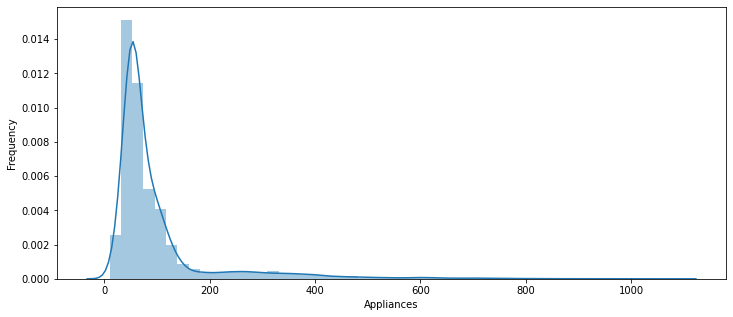

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Appliance consumption in wh')
plt.ylabel('Frequency')
sns.distplot(df['Appliances'])

The Appliances is positively skewed, most of the values are around mean 100Wh 

In [ ]:
# plt.figure(figsize=(12,5))
# plt.xlabel('Appliance consumption in wh')
# plt.ylabel('Frequency')
# sns.distplot(df['Appliances'])

In [ ]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [ ]:
temp_col = ['T1', 'T2','T3','T4','T5','T6','T7','T8','T9','T_out']

In [ ]:
humidity_col = ['RH_1', 'RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','RH_out']

In [ ]:
weather_col = ['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint']

In [ ]:
random_col = ['rv1', 'rv2']

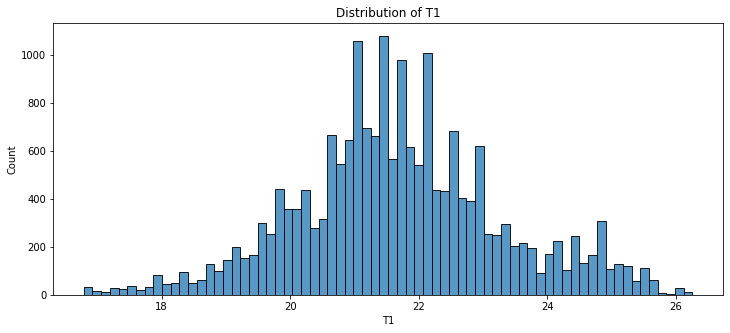

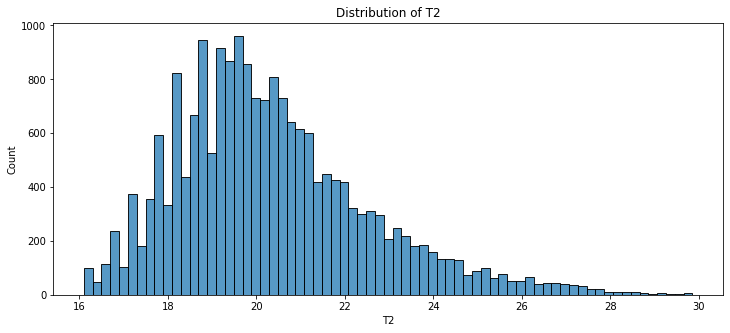

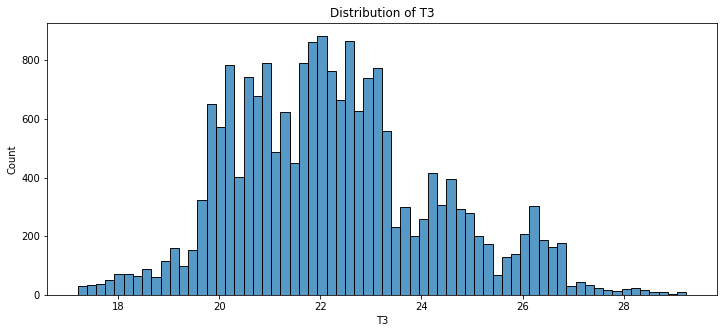

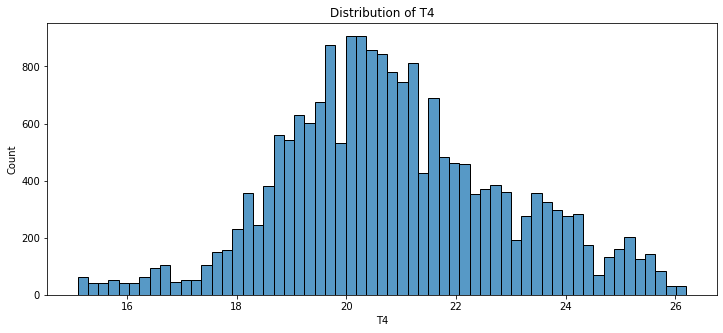

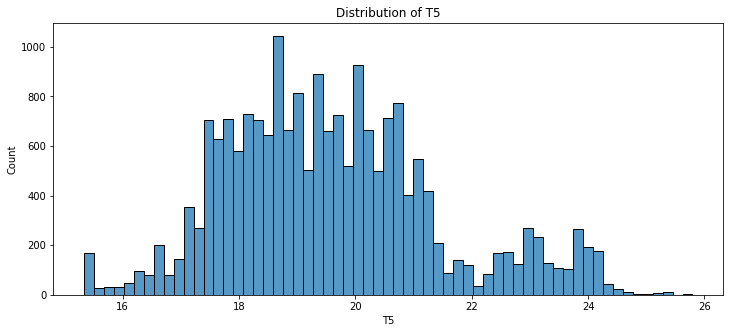

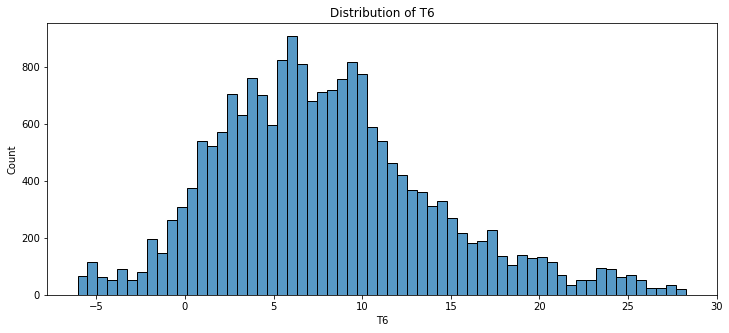

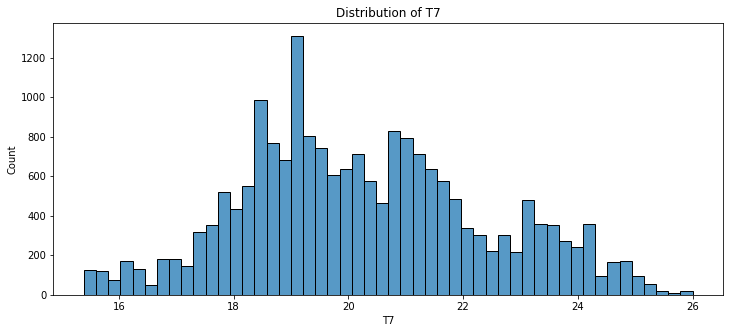

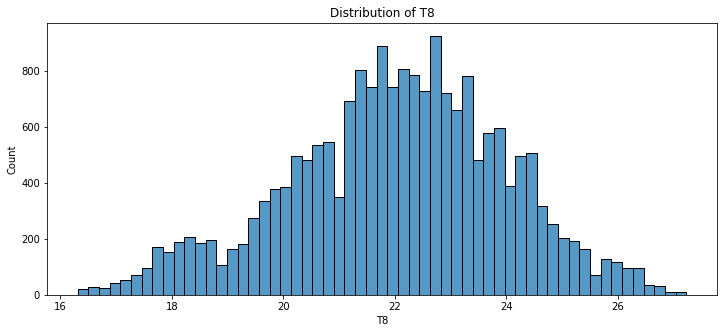

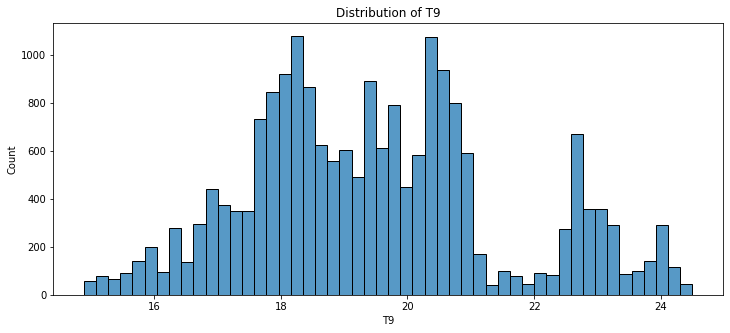

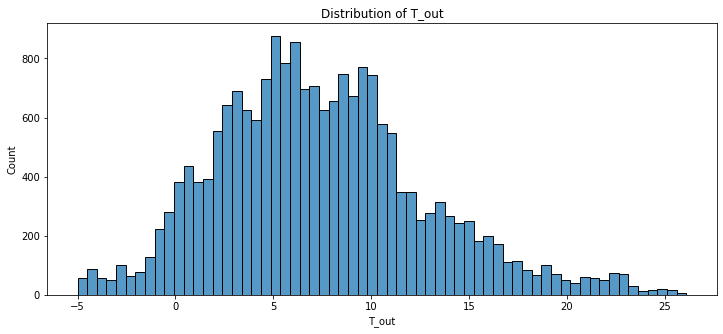

In [ ]:
for i, col in enumerate(df[temp_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

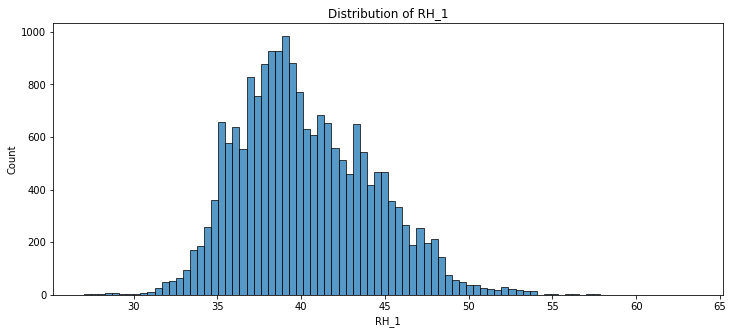

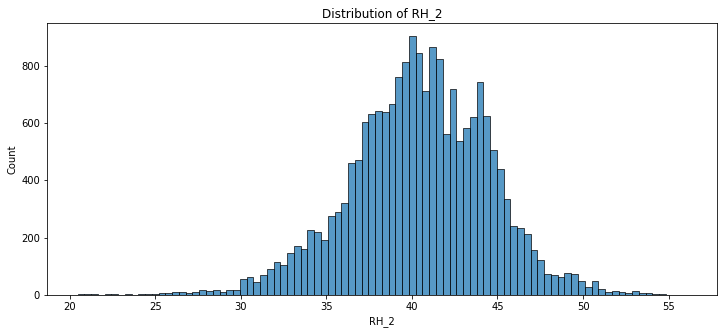

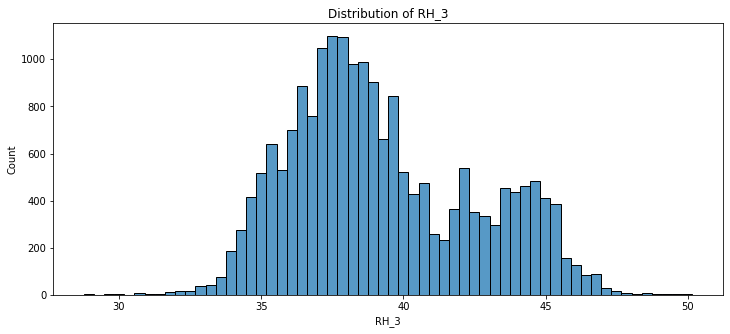

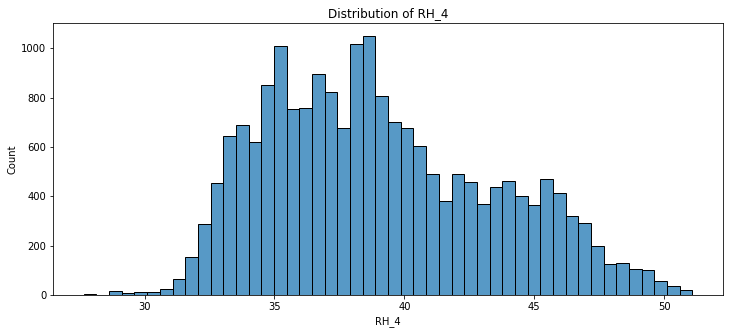

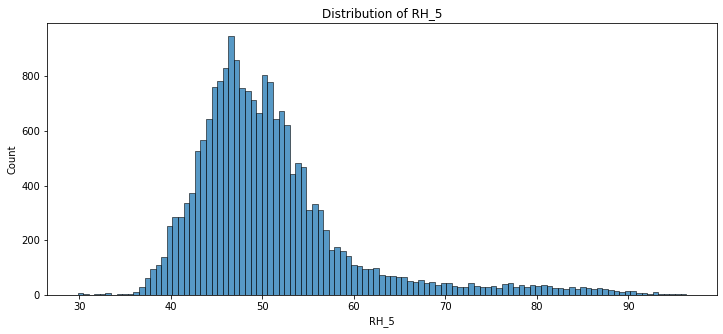

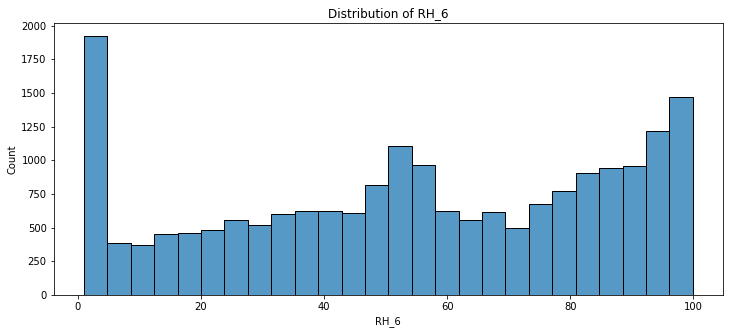

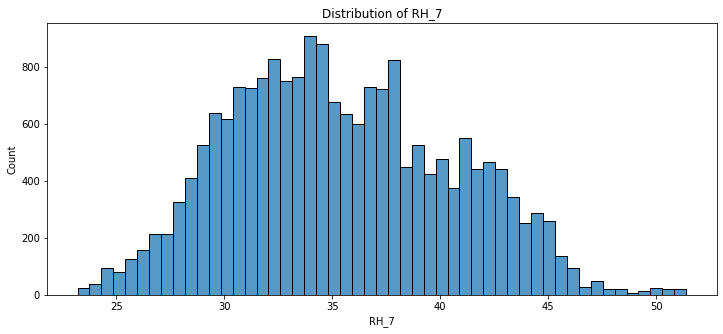

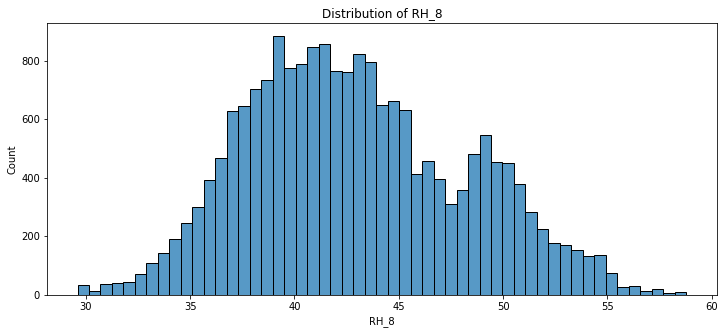

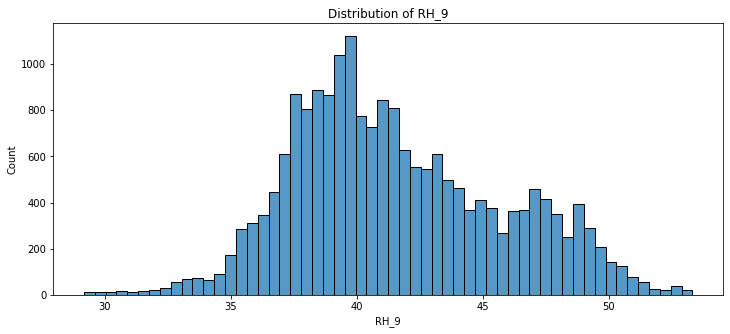

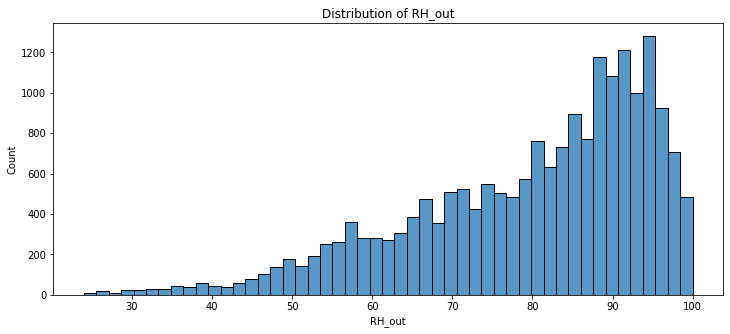

In [ ]:
for i, col in enumerate(df[humidity_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

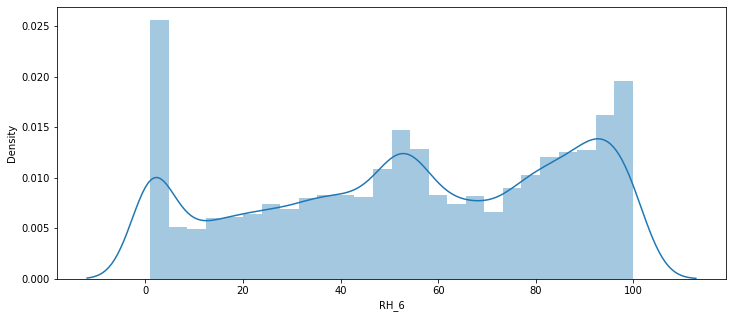

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['RH_6'])

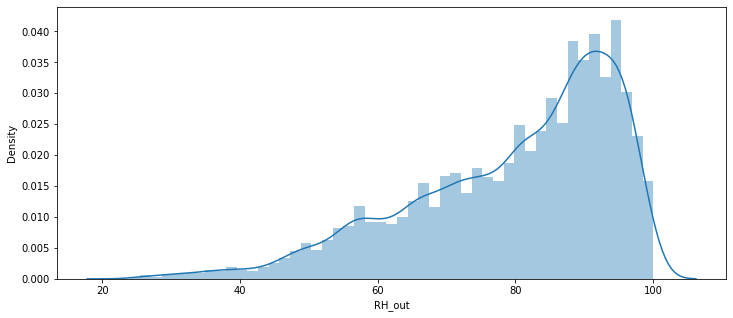

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['RH_out'])

Temperature - All the columns follow normal distribution except T9

Humidity - All columns follow normal distribution except RH_6 and RH_out, primarly because these sensors are outside the house

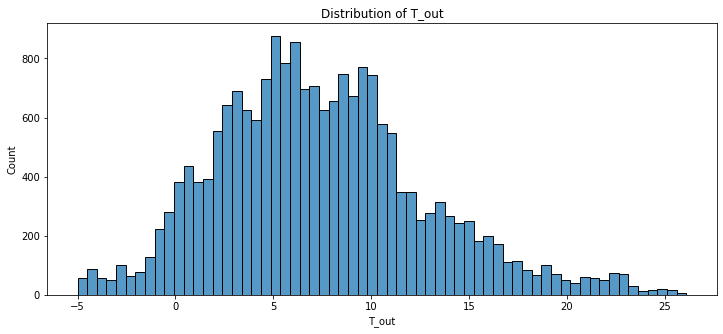

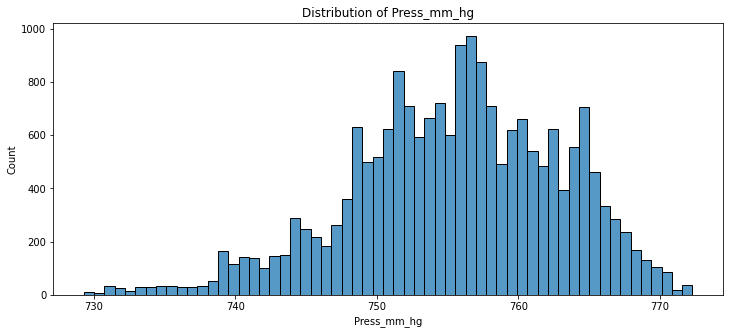

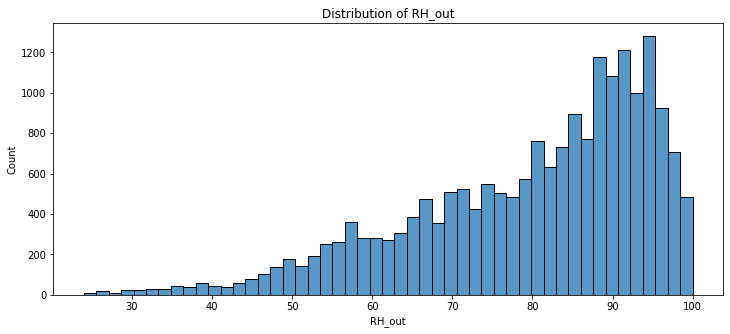

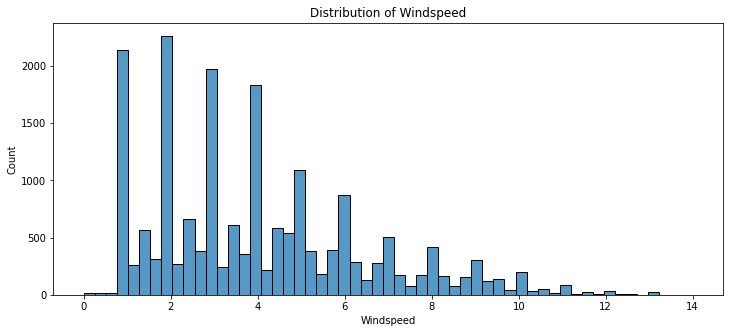

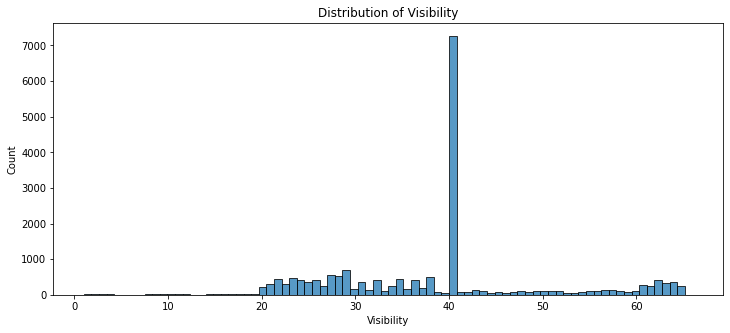

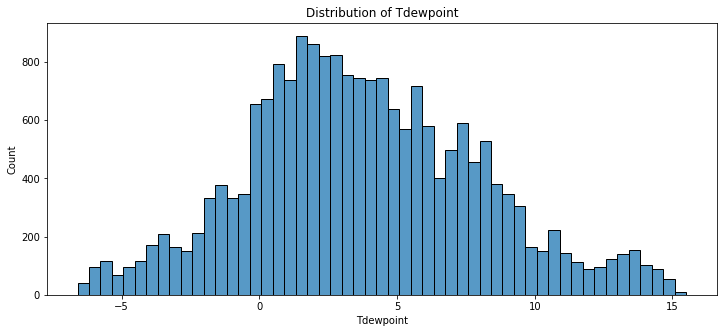

In [ ]:
for i, col in enumerate(df[weather_col]):
  plt.figure(figsize=(12,5))
  sns.histplot(data=df, x = col)
  plt.title(f'Distribution of {col}')
  plt.show()

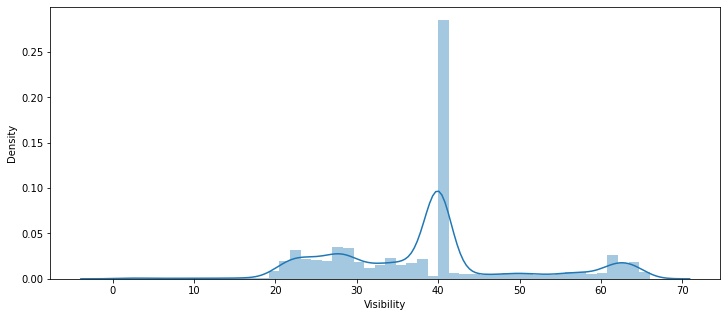

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['Visibility'])

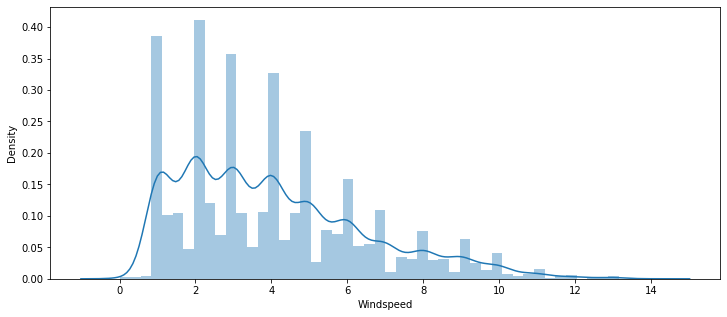

In [ ]:
plt.figure(figsize=(12,5))
sns.distplot(df['Windspeed'])

Visibility is negatively skewed


Windspeed is positively skewed

In [ ]:
df.lights.value_counts()

0     15252
10     2212
20     1624
30      559
40       77
50        9
60        1
70        1
Name: lights, dtype: int64

As here we can see the number of zeros count is 15252 which means around 90% of the values are zero

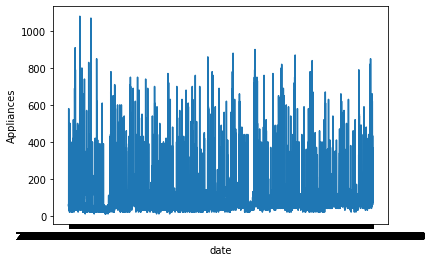

In [ ]:
sns.lineplot(df['date'],df['Appliances'])

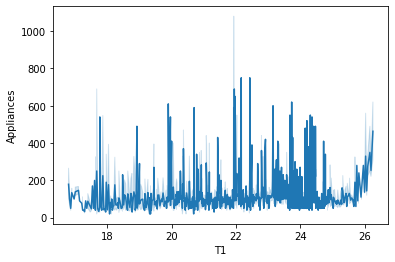

In [ ]:
sns.lineplot(df['T1'],df['Appliances'])

In [ ]:
sns.lineplot(df['date'],df['Appliances'])

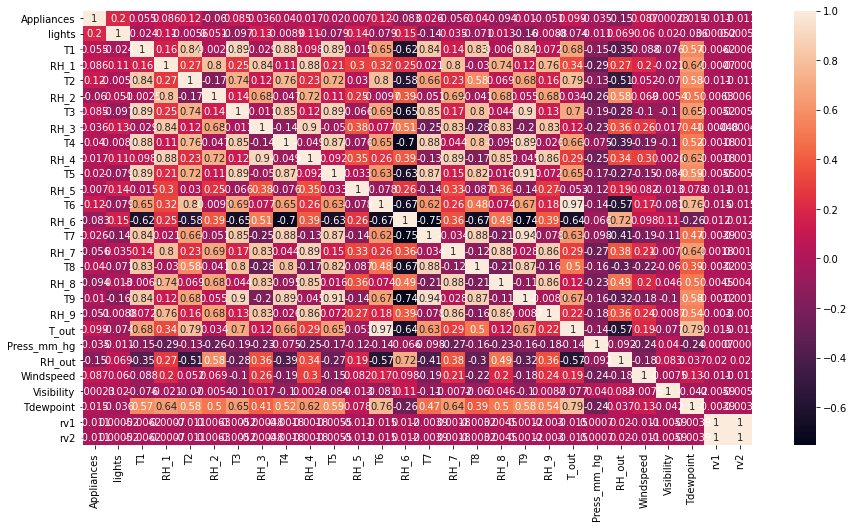

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot = True)
plt.show()

In [ ]:
df['weekday'] =((pd.to_datetime(df['date']).dt.dayofweek)// 5 == 1).astype(float)
# There are 5472 weekend recordings 
df['weekday'].value_counts()

0.0    14263
1.0     5472
Name: weekday, dtype: int64